0.26.2
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.9
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.08, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.003, entropy coefficient 0.08, and discount factor 0.9
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.01, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.01, and discount factor 0.9
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.08, and discount factor 0.4
Starting experiment with 10 vehicles, learning rate 0.0003, entropy coefficient 0.08, and discount factor 0.9
Starting experiment with 50 vehicles, learning rate 0.003, entropy coefficient 0.01, and discount factor 0.4
Starting

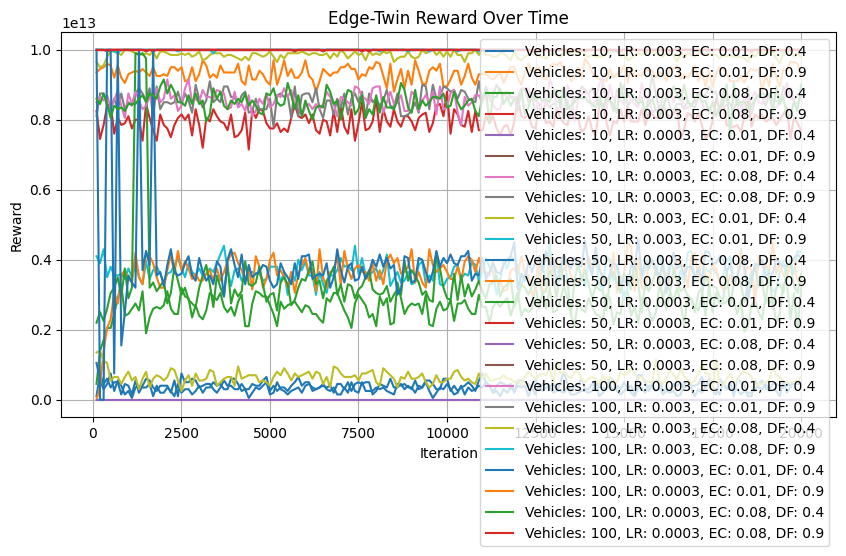

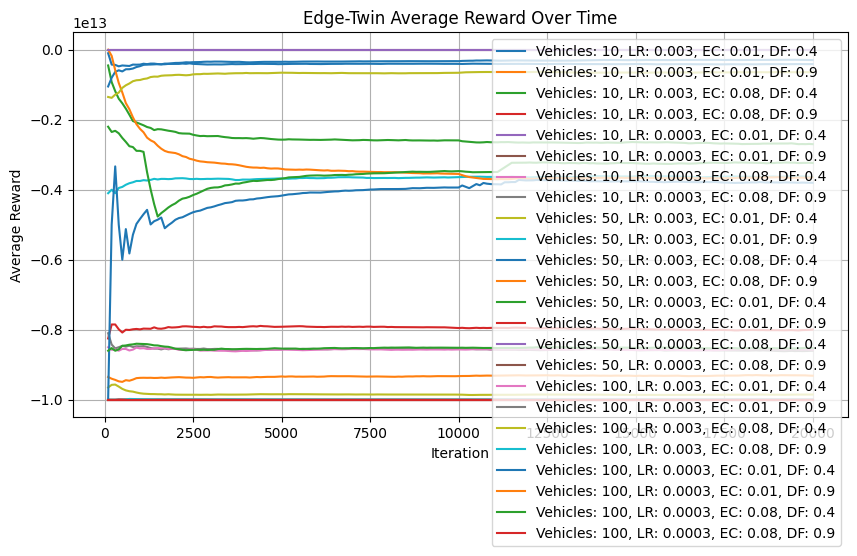

In [30]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import pandas as pd
import os

SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Define the environment

class TaskOffloadingEnv(gym.Env):
    def __init__(self, n_vehicles, F_RSU=10e9, max_steps=100): #edge full resource 10G compared to 20G in cloud case
        super(TaskOffloadingEnv, self).__init__()
        self.n = n_vehicles
        self.F_RSU = F_RSU  # Total edge resource
        self.max_steps = max_steps
        self.current_step = 0

        # Action space: discrete for offloading decisions, continuous for resource allocation
        self.action_space = spaces.Tuple((
            spaces.MultiBinary(self.n),  # n binary actions for offloading decision
            spaces.Box(low=1e9, high=2e9, shape=(self.n,), dtype=np.float32)  # Continuous resource allocation at the edge max 2G in comparison to cloud max 4G
        ))

        # Observation space: 7 features per vehicle + 3 new 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(10 * self.n,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        # Initialize the state with random values
        self.d_V = np.random.randint(31000, 31010, self.n) * 8
        self.c_V = np.random.randint(5, 6, self.n) * 1e3 / 8
        self.tau_V = np.random.randint(5, 6, self.n)
        self.bar_d_V = np.random.randint(15500, 15510, self.n) * 8
        self.f_V = np.random.randint(1, 2, self.n) * 1e9
        self.T_upload_RSU = np.random.randint(20, 21, self.n) * 1e6
        self.T_download_RSU = np.random.randint(40, 41, self.n) * 1e6
        
        ######new addded to the state
        self.T_b = np.random.randint(100, 101, self.n) * 1e6  ########## new Tb bps
        self.v_V = np.random.randint(20, 21, self.n) ###### new speed m/s
        self.R = np.random.randint(1000, 1001, self.n) ###### new RSU range m

        return np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_RSU, self.T_download_RSU, self.T_b, self.v_V, self.R])

    def step(self, action):
        self.current_step += 1

        x_V, F_RSU_V = action
        x_V = x_V.reshape(-1)  # Flatten the action array if necessary
        F_RSU_V = F_RSU_V.flatten()

        T_total = 0
        tau_total=0
        for i in range(self.n):
            tau_total+=self.tau_V[i]
            T_V_j = (self.d_V[i] / self.T_upload_RSU[i]) + ((self.d_V[i] * self.c_V[i]) / (F_RSU_V[i])) + (self.bar_d_V[i] / self.T_download_RSU[i]) +2*0.003*1e-3 #latency for reaching edge
            if x_V[i] == 0:
                T_V_i = (self.d_V[i] * self.c_V[i]) / self.f_V[i]
            else:
                if (self.v_V[i]*T_V_j) <= self.R[i]: #y_V[i]=0
                    T_V_i = T_V_j
                else: #means y_V[i]=1
                    T_V_i = (self.d_V[i] / self.T_upload_RSU[i]) + \
                        ((self.d_V[i] * self.c_V[i]) / (F_RSU_V[i])) + \
                        (self.bar_d_V[i] / self.T_download_RSU[i])+\
                        (self.v_V[i]*self.tau_V[i]*self.bar_d_V[i] /(self.R[i]*self.T_b[i]))+2*0.003*1e-3 #latency for reaching edge
            #T_vehicle[i]=T_V_i
            T_total += T_V_i

        # Ensure x_V and F_RSU_V are tensors before applying operations
        x_V = torch.as_tensor(x_V, dtype=torch.float32)
        F_RSU_V = torch.as_tensor(F_RSU_V, dtype=torch.float32)

        # Use PyTorch's sum for tensor operations
        if (torch.sum(x_V * F_RSU_V) > self.F_RSU) or (T_total>tau_total):
            reward = -1e11
        else:
        #original way
            reward = -T_total
        
        #one way
        #   alpha = 1e6  # Scaling factor to adjust the magnitude of the reward
        #   T_total = max(T_total, 1e-6)  # Prevent division by zero
        #   reward = alpha / T_total  # Higher reward for lower latency

        #another way
        #    max_latency=1000
        #    desired_reward_for_max_latency=0.1
        #    scaling_factor=-max_latency / 0.1   
        #    reward = np.exp(-T_total / scaling_factor)
            
        next_state = np.concatenate([self.d_V, self.c_V, self.tau_V, self.bar_d_V, self.f_V, self.T_upload_RSU, self.T_download_RSU, self.T_b, self.v_V, self.R])

        # Check if the episode should terminate
        done = self.current_step >= self.max_steps

        return next_state, reward, done, {}

# Define the Actor-Critic model
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, std=0.2):
        super(ActorCritic, self).__init__()
        self.common = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        self.actor_fc = nn.Linear(hidden_size, num_actions)  # Discrete action probabilities
        self.actor_fc2 = nn.Linear(hidden_size, num_actions)  # Continuous action means

        self.critic = nn.Linear(hidden_size, 1)

        self.log_std = nn.Parameter(torch.ones(1, num_actions) * std)

    def forward(self, x):
        x = self.common(x)

        probs = torch.sigmoid(self.actor_fc(x))  # Discrete action probabilities sigmoid ggives 0 1 
        means = self.actor_fc2(x)  # Continuous action means
        #means = F.softplus(means)
        #means=abs(means)
        #print("actor-critic model means", means)
        stds = self.log_std.expand_as(means)   ####################################################################################exponential
        #print("actor-critic model stds", stds)

        value = self.critic(x)

        return probs, means, stds, value


# Helper functions for PPO
def compute_returns(next_value, rewards, masks, gamma):
    R1 = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R1 = rewards[step] + gamma * R1 * masks[step]
        returns.insert(0, R1)
    return returns

def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]


# Helper functions for PPO
def ppo_update(model, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, entropy_coefficient, clip_param=0.2): #clip_parameter is the epsilon of the equation
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist_probs, means, stds, value = model(state) #dist_probs=probs=discrete action
            #print("ppo update means", means)
            #print("ppo update stds", stds)
            # Assuming action is concatenated: first part is discrete, second part is continuous shapes of actions have no problem i checked
            action_continuous = action[:, n_vehicles:]
            ##print("ppo_update action_continuous", action_continuous)
            ##print("ppo_update action_continuous_shape", action_continuous.shape)
            # Create the distributions has no porblem 
            dist_normal = Normal(means, stds)
            # Compute new log probabilities
            new_log_prob_continuous = dist_normal.log_prob(action_continuous).sum(1, keepdim=True)################################################################exponential
            ##print("new_log_prob_continuous", new_log_prob_continuous)
            ##print("new_log_prob_continuous_shape", new_log_prob_continuous.shape)


            # Assuming action is concatenated: first part is discrete, second part is continuous shapes of actions have no problem i checked
            action_discrete = action[:, :n_vehicles]  # Ensure discrete actions are long type for Categorical
            ##print("ppo_update action_discrete", action_discrete)
            ##print("ppo_update action_discrete_shape", action_discrete.shape)
            # Create the distributions
            dist_categorical = Categorical(logits=dist_probs)

            action_discrete_i_list=[]
            new_log_prob_discrete_list = []
            for i in range(n_vehicles):
                action_discrete_i = action_discrete[:, i]  # Select actions for vehicle i
                action_discrete_i_list.append(action_discrete_i.unsqueeze(-1))
                new_log_prob_discrete_i = dist_categorical.log_prob(action_discrete_i)
                new_log_prob_discrete_list.append(new_log_prob_discrete_i.unsqueeze(-1))  # Unsqueeze to prepare for stacking
            
            # Stack along the last dimension to get the shape
            
            new_action_discrete_i = torch.cat(action_discrete_i_list, dim=-1)
            new_log_prob_discrete_i = torch.cat(new_log_prob_discrete_list, dim=-1)
            ##print("action_discrete_i",new_action_discrete_i)
            ##print("action_discrete_i shape",new_action_discrete_i.shape)
            ##print("new_log_prob_discrete_i",new_log_prob_discrete_i)
            ##print("new_log_prob_discrete_i shape",new_log_prob_discrete_i.shape)
            
            #merge
            new_log_probs = new_log_prob_discrete_i + new_log_prob_continuous

            
            ratio = (new_log_probs / (old_log_probs))#.exp() #this ratio must be divided not subtract ####################################################################################exponential
            surr1 = ratio * advantage #i know what is this from youtube advantage is the gain
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            optimizer.zero_grad()
            entropy = dist_categorical.entropy().mean() + dist_normal.entropy().mean()
            #entropy_coefficient=0.08#grows to 0.1
            total_loss = actor_loss + 0.5 * critic_loss - entropy_coefficient * entropy
            total_loss.backward()

            ##these two lines treat the NaN values that are witnessed at some point in the iteration running
            # Gradient Clipping
            max_norm = 0.5  # You can adjust this value as needed
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

            optimizer.step()


# Hepler Functions for PPO 
def evaluate_policy(env, model, n_vehicles,episodes=2):
    total_reward = 0.0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                dist_probs, means, stds, _ = model(state)
                if torch.isnan(dist_probs).any() or torch.isnan(means).any() or torch.isnan(stds).any():
                    print("NaN detected in output of model")
                    # Handle the NaN case, e.g., by skipping the iteration, logging more info, or raising an error
                    continue  # or raise an exception
                action_cat = Categorical(dist_probs)
                action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
                action_discrete = action_discrete.reshape(1, n_vehicles)
                action_continuous = Normal(means, stds).sample()
                action = (action_discrete, action_continuous.numpy())
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

    average_reward = total_reward / episodes
    return average_reward

# Main training loop
# Function to run the experiment
def run_experiment(n_vehicles, learning_rate, entropy_coefficient, gama):
    env = TaskOffloadingEnv(n_vehicles=n_vehicles)
    num_inputs = env.observation_space.shape[0]
    num_actions = n_vehicles
    minimum_batch_size=64
    model = ActorCritic(num_inputs, num_actions, hidden_size=512)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    max_frames = 20000
    frame_idx = 0
    test_rewards = []
    test_rewards2 = []
    test_loss = []
    epochs_recorded = []
    epochs_recorded2 = []
    losses=[]

    state = env.reset()
    best_reward = float('-inf')  ####### new Initialize best reward seen so far


    while frame_idx < max_frames:
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []
    
        for _ in range(100):
            state = torch.FloatTensor(state).unsqueeze(0)
            dist_probs, means, stds, value = model(state)
            dist_probs = dist_probs.squeeze(0)  # Remove the batch dimension to get shape [n_vehicles]
            
            action_cat = Categorical(logits=dist_probs)
            action_discrete = action_cat.sample(sample_shape=torch.Size([n_vehicles]))
            action_discrete=action_discrete.reshape(1, n_vehicles)
            action_continuous = Normal(means, stds).sample()
            action_continuous_np = action_continuous.numpy()
            
            action = (action_discrete, action_continuous_np)
            next_state, reward, done, _ = env.step(action)
            log_prob = action_cat.log_prob(action_discrete) + Normal(means, stds).log_prob(action_continuous).sum(1, keepdim=True)
            
            states.append(state)
            actions.append(torch.cat([action_discrete, action_continuous], 1))
            rewards.append(reward)
            masks.append(1 - done)
            values.append(value)
            log_probs.append(log_prob)
    
            state = next_state
            frame_idx += 1
    
            if done:
                state = env.reset()
    
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            _, _, _, next_value = model(next_state)
            
        returns = compute_returns(next_value, rewards, masks, gamma) #found values
        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach() #actual values
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values #it is the gain or the advantage obtained from the value network
        ppo_epoch=4
        ppo_update(model, optimizer, ppo_epoch, minimum_batch_size, states, actions, log_probs, returns, advantage,entropy_coefficient)
    
        if frame_idx % 100 == 0:
            test_reward = evaluate_policy(env, model,n_vehicles)
            test_rewards.append(-1*test_reward)
            epochs_recorded.append(frame_idx)
            #print('Epoch %s. Latency: %s' % (frame_idx, test_reward))
            # Compute convergence metrics
            avg_reward = np.mean(test_rewards[-100:])  # Average reward over last 100 episodes
            avg_loss = np.mean(losses[-100:]) if losses else 0  # Average loss over last 100 iterations

            # Check for convergence based on your criteria
            if avg_reward >= best_reward:  # Example convergence criteria (can be customized)
                best_reward = avg_reward
                #torch.save(model.state_dict(), f'best_model_{n_vehicles}_{learning_rate}.pt')

            # Record metrics for plotting
            test_rewards2.append((-1*avg_reward))#np.mean([avg_reward,test_reward]))   #here here here here here
            epochs_recorded2.append(frame_idx)                                    #here here here here here

    # After running the experiment, save the results to a DataFrame
    data1 = pd.DataFrame({
        'Iteration': epochs_recorded,                                            #here here here here here
        'Avg Reward': test_rewards,                                              #here here here here here
        'Vehicles': n_vehicles,
        'Learning Rate': learning_rate,
        'Entropy Coefficient': entropy_coefficient,
        'Discount Factor': gamma
        })
    data2 = pd.DataFrame({
        'Iteration': epochs_recorded2,                                            #here here here here here
        'Avg Reward': test_rewards2,                                              #here here here here here
        'Vehicles': n_vehicles,
        'Learning Rate': learning_rate,
        'Entropy Coefficient': entropy_coefficient,
        'Discount Factor': gamma
       })
    # Append the DataFrame to the list
    all_results1.append(data1)
    all_results2.append(data2)
    
# Initialize an empty list to store experiment results
all_results1 = []
all_results2 = []
n_vehicles_options = [10,50,100]
learning_rate_options = [3e-3,3e-4]
entropy_coefficient_options = [0.01,0.08]
gamma_options = [0.4,0.9]

for n_vehicles in n_vehicles_options:
    for learning_rate in learning_rate_options:
        for entropy_coefficient in entropy_coefficient_options:
            for gamma in gamma_options:
                print(f'Starting experiment with {n_vehicles} vehicles, learning rate {learning_rate}, '
                      f'entropy coefficient {entropy_coefficient}, and discount factor {gamma}')
                run_experiment(n_vehicles, learning_rate, entropy_coefficient, gamma)

# Concatenate all DataFrames in the list into a single DataFrame
combined_results1 = pd.concat(all_results1)
combined_results2 = pd.concat(all_results2)

# Save the combined DataFrame to a CSV file
file_path1 = 'combined_results1_edge_twin_newfile_+ve+all_rewards.csv'
combined_results1.to_csv(file_path1, index=False)
file_path2 = 'combined_results2_edge_twin_newfile_+ve+all_rewards.csv'
combined_results2.to_csv(file_path2, index=False)

# Plotting and saving the results (optional)
plt.figure(figsize=(10, 5))
for n_vehicles in n_vehicles_options:
    for learning_rate in learning_rate_options:
        for entropy_coefficient in entropy_coefficient_options:  # Add different entropy coefficients
            for discount_factor in gamma_options:  # Add different discount factors
                data_subset = combined_results1[(combined_results1['Vehicles'] == n_vehicles) & 
                                               (combined_results1['Learning Rate'] == learning_rate) &
                                               (combined_results1['Entropy Coefficient'] == entropy_coefficient) &
                                               (combined_results1['Discount Factor'] == discount_factor)]
                plt.plot(data_subset['Iteration'], data_subset['Avg Reward'], label=f'Vehicles: {n_vehicles}, LR: {learning_rate}, EC: {entropy_coefficient}, DF: {discount_factor}')

plt.title("Edge-Twin Reward Over Time")
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for n_vehicles in n_vehicles_options:
    for learning_rate in learning_rate_options:
        for entropy_coefficient in entropy_coefficient_options:  # Add different entropy coefficients
            for discount_factor in gamma_options:  # Add different discount factors
                data_subset = combined_results2[(combined_results2['Vehicles'] == n_vehicles) & 
                                               (combined_results2['Learning Rate'] == learning_rate) &
                                               (combined_results2['Entropy Coefficient'] == entropy_coefficient) &
                                               (combined_results2['Discount Factor'] == discount_factor)]
                plt.plot(data_subset['Iteration'], data_subset['Avg Reward'], label=f'Vehicles: {n_vehicles}, LR: {learning_rate}, EC: {entropy_coefficient}, DF: {discount_factor}')

plt.title("Edge-Twin Average Reward Over Time")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()